In [68]:
import requests
import re
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import highlight_text as htext
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.font_manager
from PIL import Image
from io import BytesIO
from sklearn.cluster import KMeans

In [14]:
# SET SEASON, WEEK, TEAM to be plotted
SEASONS = [2022]
WEEKS = [2]
TEAMS = ['SF','KC']

In [15]:
# get team info (colors, URLS, abbr., etc.)
df_teams_info = pd.read_csv("./data/team_logos.csv")

# get pbp_participation
par = []
for SEASON in SEASONS:
    par.append(pd.read_csv(f"https://github.com/nflverse/nflverse-data/releases/download/pbp_participation/pbp_participation_{SEASON}.csv"))
df_par = pd.concat(par)
del par

# get play by play for season
cols = ['game_id',
        'play_id',
        'epa',
        'season_type',
        'season','week',
        'drive','series',
        'down',
        'ydstogo',
        'yards_gained',
        'wp',
        'ep',
        'yardline_100',
        'home_team',
        'away_team',
        'posteam',
        'defteam',
        'game_seconds_remaining',
        'game_half',
        'fixed_drive_result',
        'play_type',
        'penalty_team',
        'penalty_type',
        'penalty_yards'] #'qb_kneel','field_goal_attempt','TD_team','safety','penalty','fumble_lost','interception','fourth_down_failed']

df_pbp = nfl.import_pbp_data(years=SEASONS, columns=cols, downcast=True, cache=False)

2022 done.
Downcasting floats.


In [16]:
def get_offensive_drives(df=df_pbp, teams=TEAMS, weeks=WEEKS):
    """
     filter play-by-play data by team, week, and notnull() valued downs
    """
    conditional_team = (df['posteam'].isin(teams))
    conditional_week = (df['week'].isin(weeks))
    is_down = (df['down'].notnull())
    return df[conditional_team & conditional_week & is_down]




def getImage(team, df=df_teams_info):
    try:
        img = Image.open(f'./imgs/{team}.png')
    except:
        logoURL = df[df.team_abbr == team].team_logo_espn.tolist()[0]
        # print(logoURL)
        response = requests.get(logoURL)
        # print(response)
        img = Image.open(BytesIO(response.content))
        img.save(fp=f"./imgs/{team}.png")
    return img

In [65]:
df_teamEPA = get_offensive_drives()
df_teamEPA

,game_id,play_id,epa,season_type,week,drive,series,down,ydstogo,yards_gained,...,posteam,defteam,game_seconds_remaining,game_half,fixed_drive_result,play_type,penalty_team,penalty_type,penalty_yards,season
4104,2022_02_LAC_KC,55.0,0.043212,REG,2,1.0,1.0,1.0,10.0,5.0,...,KC,LAC,3600.0,Half1,Punt,run,None,None,NaN,2022
4105,2022_02_LAC_KC,76.0,0.299506,REG,2,1.0,1.0,2.0,5.0,4.0,...,KC,LAC,3572.0,Half1,Punt,run,None,None,NaN,2022
4106,2022_02_LAC_KC,97.0,0.656203,REG,2,1.0,1.0,3.0,1.0,6.0,...,KC,LAC,3531.0,Half1,Punt,run,None,None,NaN,2022
4107,2022_02_LAC_KC,118.0,0.597162,REG,2,1.0,2.0,1.0,10.0,10.0,...,KC,LAC,3500.0,Half1,Punt,pass,None,None,NaN,2022
4108,2022_02_LAC_KC,142.0,-0.502524,REG,2,1.0,3.0,1.0,10.0,2.0,...,KC,LAC,3458.0,Half1,Punt,pass,None,None,NaN,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5128,2022_02_SEA_SF,3458.0,2.992941,REG,2,18.0,50.0,3.0,5.0,0.0,...,SF,SEA,193.0,Half2,Touchdown,no_play,SEA,Defensive Pass Interference,19.0,2022
5129,2022_02_SEA_SF,3502.0,-0.379229,REG,2,18.0,51.0,1.0,1.0,0.0,...,SF,SEA,189.0,Half2,Touchdown,run,None,None,NaN,2022
5130,2022_02_SEA_SF,3526.0,-1.199758,REG,2,18.0,51.0,2.0,1.0,-1.0,...,SF,SEA,150.0,Half2,Touchdown,run,None,None,NaN,2022
5132,2022_02_SEA_SF,3547.0,-1.123491,REG,2,18.0,51.0,3.0,2.0,1.0,...,SF,SEA,120.0,Half2,Touchdown,run,None,None,NaN,2022


In [66]:
df_groupedEPA = df_teamEPA.groupby(['season','week','posteam']).agg({'epa':[('off_epa_sum','sum'),('off_epa_min','min'),('off_epa_max','max'),('off_epa_median','median'),('off_epa_mean','mean'),('off_epa_std','std')]})
df_groupedEPA.columns = df_groupedEPA.columns.droplevel()

In [67]:
df_teamEPA = df_teamEPA.merge(df_groupedEPA, on=['season','week','posteam'])
df_teamEPA

,game_id,play_id,epa,season_type,week,drive,series,down,ydstogo,yards_gained,...,penalty_team,penalty_type,penalty_yards,season,off_epa_sum,off_epa_min,off_epa_max,off_epa_median,off_epa_mean,off_epa_std
0,2022_02_LAC_KC,55.0,0.043212,REG,2,1.0,1.0,1.0,10.0,5.0,...,None,None,NaN,2022,2.840739,-2.883307,4.806988,-0.115430,0.043042,1.287577
1,2022_02_LAC_KC,76.0,0.299506,REG,2,1.0,1.0,2.0,5.0,4.0,...,None,None,NaN,2022,2.840739,-2.883307,4.806988,-0.115430,0.043042,1.287577
2,2022_02_LAC_KC,97.0,0.656203,REG,2,1.0,1.0,3.0,1.0,6.0,...,None,None,NaN,2022,2.840739,-2.883307,4.806988,-0.115430,0.043042,1.287577
3,2022_02_LAC_KC,118.0,0.597162,REG,2,1.0,2.0,1.0,10.0,10.0,...,None,None,NaN,2022,2.840739,-2.883307,4.806988,-0.115430,0.043042,1.287577
4,2022_02_LAC_KC,142.0,-0.502524,REG,2,1.0,3.0,1.0,10.0,2.0,...,None,None,NaN,2022,2.840739,-2.883307,4.806988,-0.115430,0.043042,1.287577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,2022_02_SEA_SF,3458.0,2.992941,REG,2,18.0,50.0,3.0,5.0,0.0,...,SEA,Defensive Pass Interference,19.0,2022,6.824444,-9.964310,4.455753,-0.181358,0.083225,1.752879
144,2022_02_SEA_SF,3502.0,-0.379229,REG,2,18.0,51.0,1.0,1.0,0.0,...,None,None,NaN,2022,6.824444,-9.964310,4.455753,-0.181358,0.083225,1.752879
145,2022_02_SEA_SF,3526.0,-1.199758,REG,2,18.0,51.0,2.0,1.0,-1.0,...,None,None,NaN,2022,6.824444,-9.964310,4.455753,-0.181358,0.083225,1.752879
146,2022_02_SEA_SF,3547.0,-1.123491,REG,2,18.0,51.0,3.0,2.0,1.0,...,None,None,NaN,2022,6.824444,-9.964310,4.455753,-0.181358,0.083225,1.752879


In [62]:
df_teamEPA[df_teamEPA.epa > (df_teamEPA.off_epa_mean + df_teamEPA.off_epa_std)].groupby(['game_id']).agg({'epa':'mean'})

,epa
game_id,
2022_02_LAC_KC,2.406224
2022_02_SEA_SF,3.041349


In [63]:
df_teamEPA[df_teamEPA.epa < (df_teamEPA.off_epa_mean - df_teamEPA.off_epa_std)].groupby(['game_id']).agg({'epa':'mean'})

,epa
game_id,
2022_02_LAC_KC,-1.888900
2022_02_SEA_SF,-4.810676


In [ ]:
# FONT FAMILY
# add font family
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-light.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-bold.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-black.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-roman.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Bebas_Neue/BebasNeue-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Bangers/Bangers-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Contrail_One/ContrailOne-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Goldman/Goldman-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Goldman/Goldman-Bold.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Permanent_Marker/PermanentMarker-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Righteous/Righteous-Regular.ttf')
# assign name of font family
azkidenz_text = "AkzidenzGrotesk"
bebas_text =  "Bebas Neue"
loma_text = "Loma"
bangers_text = "Bangers"
contrail_text = "Contrail One"
goldman_text = "Goldman"
pm_text = "Permanent Marker"
righteous_text = "Righteous"
ubuntuc_text = "Ubuntu Condensed"
padaukb_text = "Padauk Book"

# ASSIGN FONT FAMILY TO PLOT'S TEXT
title_text = bebas_text
subtitle_text = padaukb_text #ubuntuc_text
axs_label_text = contrail_text
axs_title_text = bebas_text
touchdown_text = bangers_text
drive_result_text = contrail_text
credits_text = goldman_text


# ALTERNATIVE COLOR
background ="#efefef"#"#DBDBDB" #"#808B96" straw"#e0dfd5"
text_color = "black"
title_color = "#706f6f"
axs_title_color = "black"#"#ff1d15" #"#706f6f"#"#DB3a34"#"#7cc6fe"#"#7cc6fe"
axs_title2_color = "#706f6f"
axs_label_color = "black"#"#FFC53A"
credits_text_color = text_color
spines_color = "black"
grid_color = "black"
filler_color = "white"#DE584D"#"#138bdd"
drive_start_color = "black"
drive_end_color = drive_start_color
drive_result_path_color = "black"
scatter_ec = "black"#"#fab2ea"#"#b37ba4"#"#e7e7e7"#"#2D1561"
color_list = ["#d166ff","white","#8ff856"]#["#313131","#a0a0a0","white"]#"#3650a0", #grapefruit"#c76e70" #raspberry"#A40E5B"["#CA1809","white","#48BDFF"]["#CA1809","white","#a9a9e5"] ["#b4869f","#ebf2fa","#a5be00"] ["#a06cd5","#ebf2fa","#cff27e"]["#8d89a6","#fdf6ee","#21a179"]
color_map = mpl.colors.LinearSegmentedColormap.from_list("custom_lin_colormap", color_list, N=256)
playlist_alt_color = "#191102"
playlist_text_color = text_color
penalty_color = "#faff00"
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
# flag_color = "#fdfb82"

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

x_vals = 'meanEPA'
y_vals = 'stdEPA'

cmap = matplotlib.cm.get_cmap(color_map)
# norm = mpl.colors.SymLogNorm(linthresh=0.75, vmin=league_epa_min, vmax=league_epa_max)
# plot figure, axs
fig, ax = plt.subplots(figsize=(14,14))
fig.set_facecolor(background)
ax.set_facecolor(background)
#  set properties of axis
ax.patch.set_facecolor(background)
ax.grid(ls="-", lw=0.2, color=grid_color, zorder=-10)
ax.set_title("",pad=14,loc="left", color=axs_title_color, fontweight="light", fontfamily=axs_title_text, fontsize=18)
ax.set_xlabel(f"{x_vals}",color=axs_label_color,fontfamily=axs_label_text, fontsize=12)
ax.set_ylabel(f"{y_vals}",color=axs_label_color,fontfamily=axs_label_text, fontsize=12)
ax.tick_params(axis="both",length=4, width=0.2, color=grid_color)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

spines = ["top", "right", "bottom", "left"]
for s in spines:
    if s in ["top"]:
        ax.spines[s].set_visible(False)
    elif s in ["left", "right"]:
        ax.spines[s].set_color(spines_color)
        ax.spines[s].set_linewidth(3)
        ax.spines[s].set_alpha(.2)
    else:
        ax.spines[s].set_color(spines_color)
        ax.spines[s].set_alpha(.6)

weeks = [1,2,3,4,5,6,7]
for week in weeks:
    teams = df_pbp[df_pbp.week == week].posteam.unique()
    for team in teams:
        if team != None:
            epa_stats = get_epa_stats(df_pbp, team, [week])
            x,y = epa_stats[x_vals], epa_stats[y_vals]
            img = getImage(team=team)
            img.thumbnail((32, 32))
            imagebox = OffsetImage(img)
            imagebox.image.axes = ax
            ab = AnnotationBbox(imagebox, [x, y], frameon=False)
            ax.add_artist(ab)
            ax.scatter(epa_stats[x_vals],epa_stats[y_vals], color="grey",edgecolors='white',s=120, alpha=0.5,lw=1)
                
ax.set_ylim(2.0,0.8)
plt.show()
            


In [ ]:
plt.violinplot(df_teamEPA.epa)

In [ ]:
def normEPA_btwn0and1(df_alldrives, df_week):
    min_epa = df_alldrives.epa.min()
    max_epa = df_alldrives.epa.max()
    print(min_epa,max_epa)
    return (df_week.epa-min_epa) / (max_epa - min_epa)

df_alldrives = get_offensive_drives(df=df_pbp, team='KC', weeks=[1,2,3,4,5,6,7])
df_week = get_offensive_drives(df=df_pbp, team='KC', weeks=[7])
df_notweek = get_offensive_drives(df=df_pbp, team='KC', weeks=[1,2,3,4,5,6])
week_epa_norm01 = normEPA_btwn0and1(df_alldrives, df_week)
notweek_epa_norm01 = normEPA_btwn0and1(df_alldrives, df_notweek)





fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')

for x_quantile in np.arange(0.0,1.01,0.01):
    # x=np.quantile(df_notweek.epa, x_quantile)
    # y=np.quantile(df_week.epa, x_quantile)
    x=np.quantile(notweek_epa_norm01, x_quantile)
    y=np.quantile(week_epa_norm01, x_quantile)
    # print(x, y)
    ax.scatter(x=x,y=y)
    
ax.plot(np.arange(0.0,1.1,0.01),np.arange(0.0,1.1,0.01))
# ax.plot(np.arange(-10.0,6.0,0.5),np.arange(-10.0,6.0,0.5))

plt.show()

In [ ]:
plt.violinplot(df_notweek.epa, showmeans=True, showmedians=True,showextrema=True)

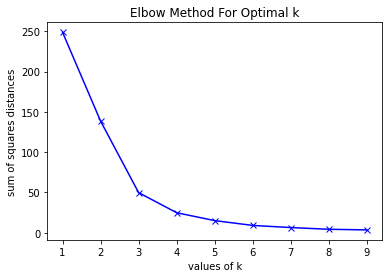

In [83]:
sum_sq_dists =[]
clusters = range(1,10)
for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=36)
    kmeans.fit(df_teamEPA[df_teamEPA.posteam == 'SF'].epa.values.reshape(-1,1))
    sum_sq_dists.append(kmeans.inertia_)
    
plt.plot(clusters, sum_sq_dists, 'bx-')
plt.xlabel("values of k")
plt.ylabel('sum of squares distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [104]:
kmeans = KMeans(n_clusters=3, random_state=36)
kmeans.fit(df_teamEPA[df_teamEPA.posteam == 'SF'].epa.values.reshape(-1,1))
print(kmeans.labels_)

In [104]:
print(kmeans.cluster_centers_)

In [105]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
for n_quantile in quantiles:
    print(np.quantile(df_teamEPA[df_teamEPA.posteam == 'SF'].epa, n_quantile))

-1.1658014893531798
-0.6919916421175003
-0.18135783821344376
0.8997358977794647
2.1424452900886566


In [98]:
df_teamEPA.loc[df_teamEPA.posteam == 'SF', 'kmeans_labels'] = kmeans.labels_

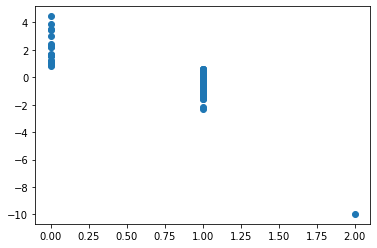

In [99]:
plt.scatter(df_teamEPA.loc[df_teamEPA.posteam == 'SF'].kmeans_labels, df_teamEPA.loc[df_teamEPA.posteam == 'SF'].epa)

In [103]:
df_teamEPA[df_teamEPA.posteam == 'SF'].kmeans_labels.value_counts()

1.0    59
0.0    22
2.0     1
Name: kmeans_labels, dtype: int64